# AIRL with TransactionsGraphEnvironment v2

In [138]:
import ast
import pickle

import gymnasium as gym
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from imitation.algorithms.adversarial.airl import AIRL
from imitation.data.rollout import flatten_trajectories
from imitation.data.types import Trajectory
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util import logger
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecCheckNan
from stable_baselines3.ppo import MlpPolicy

import graph_reinforcement_learning_using_blockchain_data as grl
from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()
mlflow.set_tracking_uri(uri=config.MLFLOW_TRACKING_URI)

In [2]:
RNG = np.random.default_rng(seed=42)

## Dataset 

In [3]:
df_emb = pd.read_csv(config.FLASHBOTS_Q2_DATA_DIR / "state_embeddings.csv")
df_class0 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class0.csv")
df_class1 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class1.csv")
df_eth_balances_class1 = pd.read_csv(config.RAW_DATA_DIR / "eth_balances_class1.csv")
df_eth_balances_class0 = pd.read_csv(config.RAW_DATA_DIR / "eth_balances_class0.csv")

with open(config.FLASHBOTS_Q2_DATA_DIR / "train_accounts.pkl", "rb") as f:
    train_accounts = pickle.load(f)

with open(config.FLASHBOTS_Q2_DATA_DIR / "test_accounts.pkl", "rb") as f:
    test_accounts = pickle.load(f)

In [4]:
print(df_class0.columns)
print(df_eth_balances_class0.columns)

Index(['block_number', 'transaction_hash', 'blockHash', 'blockNumber',
       'logsBloom', 'gasUsed', 'contractAddress', 'cumulativeGasUsed',
       'transactionIndex', 'from', 'to', 'type', 'effectiveGasPrice', 'logs',
       'status'],
      dtype='object')
Index(['account', 'block_number', 'balance'], dtype='object')


In [5]:
df_class0_with_eth_balances = df_class0.merge(
    df_eth_balances_class0,
    left_on=["from", "blockNumber"],
    right_on=["account", "block_number"],
    how="inner",
)
df_class1_with_eth_balances = df_class1.merge(
    df_eth_balances_class1,
    left_on=["from", "blockNumber"],
    right_on=["account", "block_number"],
    how="inner",
)

In [6]:
df_class0_multi_occ = df_class0_with_eth_balances[
    df_class0_with_eth_balances["from"].duplicated(keep=False)
]

In [7]:
df_emb["embeddings"] = df_emb["embeddings"].apply(
    lambda x: np.array(ast.literal_eval(x), dtype=np.float32)
)

In [8]:
df_class0_with_eth_balances["label"] = 0
df_class1_with_eth_balances["label"] = 1

In [9]:
df_receipts = pd.concat(
    [df_class0_with_eth_balances, df_class1_with_eth_balances], ignore_index=True
)
df_receipts.drop_duplicates("transaction_hash", inplace=True)
df = df_receipts.merge(df_emb, how="right", left_on="transaction_hash", right_on="transactionHash")

In [10]:
df.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,created_at,account_address,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674..."
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ..."
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,..."
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ..."
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ..."


In [11]:
df_median_gas_prices = pd.DataFrame(
    {
        "median_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].median(),
        "std_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].std(),
        "max_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].max(),
        "min_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].min(),
    }
)

df_with_median_gas_prices = df.merge(df_median_gas_prices, how="left", on="blockNumber")
df_with_median_gas_prices.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,end_amount,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674...",2.841278e+10,5.338623e+09,40046142239,27985774295
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ...",3.132425e+10,1.310671e+10,62912040686,29651658352
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,...",4.701599e+10,9.483538e+10,298140379626,44115991364
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ...",3.997607e+10,2.216894e+10,72384430845,29976074199
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ...",2.695208e+10,3.320303e+09,30915355327,22915355327


In [12]:
df_with_actions = df_with_median_gas_prices.copy()
df_with_actions["action"] = df_with_median_gas_prices.apply(
    lambda r: 1 if r["effectiveGasPrice"] > r["median_gas_price"] else 0, axis=1
)

In [13]:
df_with_actions["action"].mean()

0.24449359876667337

In [14]:
df_with_actions.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674...",2.841278e+10,5.338623e+09,40046142239,27985774295,1
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ...",3.132425e+10,1.310671e+10,62912040686,29651658352,1
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,...",4.701599e+10,9.483538e+10,298140379626,44115991364,1
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ...",3.997607e+10,2.216894e+10,72384430845,29976074199,0
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ...",2.695208e+10,3.320303e+09,30915355327,22915355327,1


In [15]:
df_with_actions.rename(columns={"balance": "eth_balance"}, inplace=True)
df_with_actions["eth_balance"] = df_with_actions["eth_balance"].astype("float64")
df_with_actions["median_gas_price"] = df_with_actions["median_gas_price"].astype("float64")
df_with_actions["std_gas_price"] = df_with_actions["std_gas_price"].astype("float64")
df_with_actions["from"] = df_with_actions["from"].astype("string")
df_with_actions["to"] = df_with_actions["to"].astype("string")
df_with_actions.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[-1.0455092, -0.45075172, -1.2988981, 0.689674...",2.841278e+10,5.338623e+09,40046142239,27985774295,1
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-6.1341934, -4.090339, -6.813894, 2.9215977, ...",3.132425e+10,1.310671e+10,62912040686,29651658352,1
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-5.403815, -3.6793585, -6.4153795, 2.0699742,...",4.701599e+10,9.483538e+10,298140379626,44115991364,1
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-7.711429, -5.4846554, -9.181214, 2.5007846, ...",3.997607e+10,2.216894e+10,72384430845,29976074199,0
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-10.870382, -8.408549, -12.329528, 6.705676, ...",2.695208e+10,3.320303e+09,30915355327,22915355327,1


In [16]:
df_with_actions[df_with_actions["std_gas_price"].isna() == True]

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
63,16975107,0xd05a59ef18204af79ae9bf2a7ba722bca892055819c7...,0x8d8cd7dfa64a3867f12d472be895ee2a1b163d854a02...,16975107,0x00200000000000000000000080000000000008000000...,196537,NaN,685900,5,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,6855415086744551,NaN,"[""uniswap_v2""]",0xd05a59ef18204af79ae9bf2a7ba722bca892055819c7...,"[4.5761786, 6.5636315, 3.3592527, -2.8692067, ...",3.442311e+10,NaN,34423111170,34423111170,0
65,16976564,0x5530313d0b0271506691e3732c517172d5bfa1b2ba3d...,0x458b66a35808bf44a7e332b9f9b326ca8660952ab40a...,16976564,0x00200000000000000000000080000000200000000000...,190691,NaN,1322470,7,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,7796163749018364,NaN,"[""uniswap_v2""]",0x5530313d0b0271506691e3732c517172d5bfa1b2ba3d...,"[3.4024527, 5.283112, 2.2056818, -2.9582765, 8...",4.041179e+10,NaN,40411786608,40411786608,0
76,16979829,0xe47601937f0538ecc2a67c0a1b2481a1d339b52b2ef0...,0x4d1ebc8a72732a87fb083679233a06cf0a33ec984b35...,16979829,0x00200000000000000000000084000000200000000000...,158198,NaN,158198,0,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,24408839782523421,NaN,"[""uniswap_v2"",""uniswap_v3""]",0xe47601937f0538ecc2a67c0a1b2481a1d339b52b2ef0...,"[6.823197, 9.531916, 5.651215, -3.9661467, 12....",1.532201e+11,NaN,153220129205,153220129205,0
98,16992014,0x23e05562df7784836aaf6c8235d2aca5501621e6aab2...,0x8794222099471416ba2721137ee0e0d60a149b2f2029...,16992014,0x00200000000000000000000080000200000000000000...,219788,NaN,219788,0,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,35168219119161781,NaN,"[""uniswap_v2"",""uniswap_v3""]",0x23e05562df7784836aaf6c8235d2aca5501621e6aab2...,"[3.409607, 5.0597196, 2.8262546, -2.1056595, 6...",1.595249e+11,NaN,159524873969,159524873969,0
167,17240935,0x74e6628155b2f61c067a568235c952e3c1fa4aa22d76...,0xa658109201d2dcd46dcc9f5ad1c71d29d6942c44b1c4...,17240935,0x00000000040000000000000000000000000000000000...,210289,NaN,2954344,23,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,13097045417966494,NaN,"[""uniswap_v3""]",0x74e6628155b2f61c067a568235c952e3c1fa4aa22d76...,"[5.1223907, 7.9230337, 4.8604784, -1.8773488, ...",6.190800e+10,NaN,61907998723,61907998723,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149181,17296632,0x2f06cc7f885dd98fbf765ad57706fe505c5b63478928...,0x64522455567aa9a4209551fd938a1e31b448487ac157...,17296632,0x00200000000000000010000080000000000000000000...,178376,NaN,440031,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,22902832502491512,NaN,"[""uniswap_v2""]",0x2f06cc7f885dd98fbf765ad57706fe505c5b63478928...,"[9.8747, 15.316246, 9.5223255, -5.324061, 16.4...",3.450291e+10,NaN,34502909809,34502909809,0
149182,17297932,0xd477617aaa93aad5aa5f5a2f880f3e934b70a91cd523...,0x493341206c063a7ba6c85137473b17f697ed72701c07...,17297932,0x00200000000000000010000080000000000000000000...,178388,NaN,440065,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,31467600199400760,NaN,"[""uniswap_v2""]",0xd477617aaa93aad5aa5f5a2f880f3e934b70a91cd523...,"[12.2059765, 19.282898, 11.881564, -6.684133, ...",2.928406e+10,NaN,29284056698,29284056698,0
149183,17298360,0xda0b7b1156a57ff85ef5c2e80f47d6fc0c89c6253fca...,0x21a1c5ae76e2cbff779f308288e1cf2273d999f978e1...,17298360,0x00200000000000000010000080000000000000000000...,178352,NaN,439975,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,38228015952142520,NaN,"[""uniswap_v2""]",0xda0b7b1156a57ff85ef5c2e80f47d6fc0c89c6253fca...,"[14.737251, 23.417326, 14.310656, -8.357638, 2...",2.959543e+10,NaN,29595427147,29595427147,0
149184,17298379,0x7755b8553cc9f2479e5cc48ebf18dd6f25fe038a668f...,0xa0171ad96bcd73eb6aa92c8da1e3a8629c1c067ea811...,17298379,0x00200000000000000010000080000000000000000000...,178364,NaN,1162669,7,0xffFf14106945bCB267

In [17]:
df_with_actions = df_with_actions.fillna({"std_gas_price": 0})

In [18]:
df_with_actions_0 = df_with_actions[df_with_actions["label"] == 0]
df_with_actions_1 = df_with_actions[df_with_actions["label"] == 1]

In [19]:
validation_accounts, test_accounts_excl_val = train_test_split(
    test_accounts, test_size=0.5, random_state=42
)

In [20]:
df_with_actions_0_train = df_with_actions_0[df_with_actions_0["from"].isin(train_accounts)]
df_with_actions_0_val = df_with_actions_0[df_with_actions_0["from"].isin(validation_accounts)]
df_with_actions_0_test = df_with_actions_0[df_with_actions_0["from"].isin(test_accounts_excl_val)]

In [21]:
df_with_actions_1_train = df_with_actions_1[df_with_actions_1["from"].isin(train_accounts)]
df_with_actions_1_val = df_with_actions_1[df_with_actions_1["from"].isin(validation_accounts)]
df_with_actions_1_test = df_with_actions_1[df_with_actions_1["from"].isin(test_accounts_excl_val)]

In [22]:
df_val = pd.concat([df_with_actions_0_val, df_with_actions_1_val])

## Creating trajectories

In [23]:
def extract_trajectories(df: pd.DataFrame):
    trajectories = []
    for account, group in df.groupby("from"):
        group = group.sort_values("blockNumber")
        obs_list = group["embeddings"].tolist() + [np.zeros(128, dtype=np.float32)]
        traj = {
            "obs": np.stack(obs_list),  # Convert list of arrays to a single numpy array
            "acts": np.array(group["action"].tolist()),
            "label": group["label"].iloc[0],
        }
        trajectories.append(traj)
    return trajectories


trajectories_1_train = extract_trajectories(df_with_actions_1_train)
trajectories_0_train = extract_trajectories(df_with_actions_0_train)
trajectories_1_test = extract_trajectories(df_with_actions_1_test)
trajectories_0_test = extract_trajectories(df_with_actions_0_test)
trajectories_val = extract_trajectories(df_val)

In [24]:
trajectories_1 = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_1_train
]
trajectories_0 = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_0_train
]
trajectories_val = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_val
]

trajectories_1 = flatten_trajectories(trajectories_1)
trajectories_0 = flatten_trajectories(trajectories_0)
trajectories_val = flatten_trajectories(trajectories_val)

In [25]:
trajectories_1_test = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_1_test
]
trajectories_0_test = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_0_test
]

trajectories_1_test = flatten_trajectories(trajectories_1_test)
trajectories_0_test = flatten_trajectories(trajectories_0_test)

## Setting up environments

In [26]:
ID0 = "gymnasium_env/TransactionGraphEnv0-v2"
gym.envs.register(
    id=ID0,
    entry_point=grl.TransactionGraphEnvV2,
    kwargs={"df": df_with_actions_0, "alpha": 0.9, "device": torch.device("mps"), "label": 0},
    max_episode_steps=300,
)

ID1 = "gymnasium_env/TransactionGraphEnv1-v2"
gym.envs.register(
    id=ID1,
    entry_point=grl.TransactionGraphEnvV2,
    kwargs={"df": df_with_actions_1, "alpha": 0.9, "device": torch.device("mps"), "label": 1},
    max_episode_steps=300,
)

In [27]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v2
LunarLander-v2         LunarLanderContinuous-v2
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
HalfCheetah-v2         HalfCheetah-v3         HalfCheetah-v4
Hopper-v2              Hopper-v3              Hopper-v4
Humanoid-v2            Humanoid-v3            Humanoid-v4
HumanoidStandup-v2     HumanoidStandup-v4     InvertedDoublePendulum-v2
InvertedDoublePendulum-v4 InvertedPendulum-v2    InvertedPendulum-v4
Pusher-v2              Pusher-v4              Reacher-v2
Reacher-v4         

In [28]:
env0 = Monitor(gym.make(ID0))

venv0 = make_vec_env(
    ID0,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env0, _: RolloutInfoWrapper(env0)],
    parallel=False,
)

venv0 = VecCheckNan(venv0, raise_exception=True)  # Check for NaN observations
venv0.reset()

array([[-1.1937809 , -0.5178503 , -1.4873717 ,  0.7746816 , -1.2721511 ,
         1.9958754 ,  0.9333747 , -1.1518404 , -1.0313634 ,  1.3020712 ,
        -0.11748054,  0.19454235,  0.345848  ,  0.3982893 , -1.5058204 ,
        -1.2664857 , -0.8590805 ,  1.531701  ,  1.1555969 ,  1.6039811 ,
        -0.18072817,  0.5784119 ,  0.18430722,  0.5409156 , -1.5086141 ,
        -0.9192162 ,  0.7229177 , -1.1182932 ,  1.1571454 ,  0.70637596,
        -1.2899321 ,  0.7506848 ,  1.345654  , -0.749489  ,  1.254042  ,
         0.21244039,  1.9581863 ,  0.9482627 ,  0.892879  ,  0.01640163,
        -0.2060627 ,  1.4063177 , -0.28646436,  0.17685914, -1.606246  ,
        -0.5051448 ,  0.7188016 ,  0.9673055 ,  0.9617047 ,  1.4920721 ,
         0.5105487 , -0.13505933,  1.1374019 , -1.0920327 ,  0.821553  ,
        -1.0782628 ,  0.9702494 , -1.0197232 , -1.4586146 ,  0.85779065,
         1.4360079 ,  0.66978604, -1.0313015 , -1.8518924 , -0.61324686,
        -1.4530989 ,  0.6793852 , -2.242465  ,  0.1

In [29]:
env1 = Monitor(gym.make(ID1))

venv1 = make_vec_env(
    ID1,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env1, _: RolloutInfoWrapper(env1)],
    parallel=False,
)

venv1 = VecCheckNan(venv1, raise_exception=True)  # Check for NaN observations
venv1.reset()

array([[ 2.1050785 ,  2.9409041 ,  2.7491593 , -0.90090597,  3.34102   ,
        -1.0163782 , -3.628866  ,  1.7879648 , -0.41493422, -2.257103  ,
         0.17917961, -5.5413423 , -3.187664  , -1.0074005 ,  3.8020494 ,
         1.867261  ,  5.3037596 , -2.5561662 , -3.1998749 , -3.1663272 ,
         2.4884343 ,  3.8236866 ,  0.6439351 , -3.8735547 ,  0.34911406,
         1.3782847 , -4.0826197 ,  0.25616807, -2.5234458 , -1.987067  ,
         0.5799383 , -1.5068438 ,  3.2463756 , -1.0692186 , -3.016827  ,
        -3.0377662 ,  1.5168358 , -3.3340023 , -3.153436  ,  4.7484083 ,
         0.818479  , -2.3471856 , -1.0186008 ,  3.4683278 ,  1.7480986 ,
         1.5406379 , -0.77182394, -1.4625266 , -2.89302   , -2.5207417 ,
        -0.4640103 ,  2.423791  , -1.465664  ,  4.614048  , -1.4057485 ,
        -3.2410553 , -3.822288  , -7.75205   ,  1.7975447 , -1.1890996 ,
        -1.2437905 , -3.8492424 ,  1.6798604 ,  0.6190152 , -3.506558  ,
         3.7543266 ,  0.23060143,  3.0399046 ,  0.4

## AIRL setup

In [30]:
# Set parameters for the PPO algorithm (generator)
learning_rate = 0.001  # Learning rate, can be a function of progress
batch_size = 60  # Mini batch size for each gradient update
n_epochs = 15  # N of epochs when optimizing the surrogate loss

gamma = 0.5  # Discount factor, focus on the recent rewards
gae_lambda = 0  # Generalized advantage estimation
clip_range = 0.1  # Clipping parameter
ent_coef = 0.01  # Entropy coefficient for the loss calculation
vf_coef = 0.5  # Value function coef. for the loss calculation
max_grad_norm = 0.5  # The maximum value for the gradient clipping

verbose = 0  # Verbosity level: 0 no output, 1 info, 2 debug
normalize_advantage = True  # Whether to normalize or not the advantage

clip_range_vf = None  # Clip for the value function
use_sde = False  # Use State Dependent Exploration
sde_sample_freq = -1  # SDE - noise matrix frequency (-1 = disable)

# Set parameters for the AIRL trainer
gen_replay_buffer_capacity = None
allow_variable_horizon = True

disc_opt_kwargs = {
    "lr": 0.001,
}
policy_kwargs = {"use_expln": True}  # Fixing an issue with NaNs

In [31]:
# Set the number of timesteps, batch size and number of disc updates

# Total number of timesteps in the whole training
total_timesteps = 3000 * 100

# Generator
gen_train_timesteps = 3000  # N steps in the environment per one round
n_steps = gen_train_timesteps

# Discriminator batches
demo_minibatch_size = 60  # N samples in minibatch for one discrim. update
demo_batch_size = 300 * 10  # N samples in the batch of expert data (batch)
n_disc_updates_per_round = 4  # N discriminator updates per one round

In [32]:
hier_logger = logger.configure()
hier_logger.default_logger.output_formats.append(grl.MLflowOutputFormat())

In [33]:
# Initialize the learner PPO policy (generator)
learner0 = PPO(
    env=venv0,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

reward_net0 = BasicShapedRewardNet(
    observation_space=venv0.observation_space,
    action_space=venv0.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer0 = AIRL(
    demonstrations=trajectories_0,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv0,
    gen_algo=learner0,
    reward_net=reward_net0,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
    custom_logger=hier_logger,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [34]:
# Initialize the learner PPO policy (generator)
learner1 = PPO(
    env=venv1,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

reward_net1 = BasicShapedRewardNet(
    observation_space=venv1.observation_space,
    action_space=venv1.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer1 = AIRL(
    demonstrations=trajectories_1,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv1,
    gen_algo=learner1,
    reward_net=reward_net1,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
    custom_logger=hier_logger,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


## Training AIRL discriminator and generator, stats are saved with mlflow

We need to train 2 distinct airl trainers, one for arbitrage transactions and the other for class 0 transactions. The goal is to use the resulting reward functions to do classification.

In [ ]:
mlflow.set_experiment("AIRLv2")

with mlflow.start_run():
    mlflow.log_param("n_steps", n_steps)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("total_timesteps", total_timesteps)

    airl_trainer1.train(total_timesteps=total_timesteps)

    learner1.save(config.MODELS_DIR / "learner1v2")
    torch.save(reward_net1, config.MODELS_DIR / "reward_net1v2")

    mlflow.log_artifact(config.MODELS_DIR / "learner1v2.zip")
    mlflow.log_artifact(config.MODELS_DIR / "reward_net1v2")
    mlflow.end_run()

In [35]:
mlflow.set_experiment("AIRLv2")
with mlflow.start_run():
    mlflow.log_param("n_steps", n_steps)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("total_timesteps", total_timesteps)

    airl_trainer0.train(total_timesteps=total_timesteps)

    learner0.save(config.MODELS_DIR / "learner0v2")
    torch.save(reward_net0, config.MODELS_DIR / "reward_net0v2")

    mlflow.log_artifact(config.MODELS_DIR / "learner0v2.zip")
    mlflow.log_artifact(config.MODELS_DIR / "reward_net0v2")
    mlflow.end_run()

round:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 3.8      |
|    gen/rollout/ep_rew_mean  | 1.36     |
|    gen/time/fps             | 47       |
|    gen/time/iterations      | 1        |
|    gen/time/time_elapsed    | 63       |
|    gen/time/total_timesteps | 3000     |
------------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.603    |
|    disc/disc_loss                   | 0.0158   |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 60       |
|    disc/n_generated                 | 60       |
-

round:   1%|          | 1/100 [01:13<2:00:45, 73.19s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.02         |
|    gen/rollout/ep_rew_mean         | 1.01         |
|    gen/rollout/ep_rew_wrapped_mean | 6.06         |
|    gen/time/fps                    | 58           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 51           |
|    gen/time/total_timesteps        | 6000         |
|    gen/train/approx_kl             | 0.0016694383 |
|    gen/train/clip_fraction         | 0.0543       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.692       |
|    gen/train/explained_variance    | 0.0105       |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.939        |
|    gen/train/n_updates             | 15           |
|    gen/train/policy_gradient_loss  | -0.00122     |
|    gen/train/value_loss   

round:   2%|▏         | 2/100 [02:11<1:45:24, 64.54s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.98         |
|    gen/rollout/ep_rew_mean         | 1.51         |
|    gen/rollout/ep_rew_wrapped_mean | -0.343       |
|    gen/time/fps                    | 50           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 59           |
|    gen/time/total_timesteps        | 9000         |
|    gen/train/approx_kl             | 0.0022485028 |
|    gen/train/clip_fraction         | 0.08         |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.69        |
|    gen/train/explained_variance    | -1.91        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.157        |
|    gen/train/n_updates             | 30           |
|    gen/train/policy_gradient_loss  | -0.000149    |
|    gen/train/value_loss   

round:   3%|▎         | 3/100 [03:19<1:46:27, 65.86s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 7.77        |
|    gen/rollout/ep_rew_mean         | 3.29        |
|    gen/rollout/ep_rew_wrapped_mean | -1          |
|    gen/time/fps                    | 50          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 59          |
|    gen/time/total_timesteps        | 12000       |
|    gen/train/approx_kl             | 0.005060752 |
|    gen/train/clip_fraction         | 0.362       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.67       |
|    gen/train/explained_variance    | 0.0386      |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.024       |
|    gen/train/n_updates             | 45          |
|    gen/train/policy_gradient_loss  | -0.00849    |
|    gen/train/value_loss            | 0.066  

round:   4%|▍         | 4/100 [04:25<1:45:36, 66.00s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.35        |
|    gen/rollout/ep_rew_mean         | 2.99        |
|    gen/rollout/ep_rew_wrapped_mean | -2.89       |
|    gen/time/fps                    | 57          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 52          |
|    gen/time/total_timesteps        | 15000       |
|    gen/train/approx_kl             | 0.004899096 |
|    gen/train/clip_fraction         | 0.351       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.646      |
|    gen/train/explained_variance    | 0.731       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.00708    |
|    gen/train/n_updates             | 60          |
|    gen/train/policy_gradient_loss  | -0.0148     |
|    gen/train/value_loss            | 0.0174 

round:   5%|▌         | 5/100 [05:24<1:40:51, 63.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.2          |
|    gen/rollout/ep_rew_mean         | 2.64         |
|    gen/rollout/ep_rew_wrapped_mean | -2.48        |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 18000        |
|    gen/train/approx_kl             | 0.0059194253 |
|    gen/train/clip_fraction         | 0.359        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.618       |
|    gen/train/explained_variance    | 0.759        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | -0.0246      |
|    gen/train/n_updates             | 75           |
|    gen/train/policy_gradient_loss  | -0.0188      |
|    gen/train/value_loss   

round:   6%|▌         | 6/100 [06:22<1:36:29, 61.59s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.1         |
|    gen/rollout/ep_rew_mean         | 2.48        |
|    gen/rollout/ep_rew_wrapped_mean | -2.52       |
|    gen/time/fps                    | 45          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 65          |
|    gen/time/total_timesteps        | 21000       |
|    gen/train/approx_kl             | 0.006848295 |
|    gen/train/clip_fraction         | 0.339       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.575      |
|    gen/train/explained_variance    | 0.774       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.0304     |
|    gen/train/n_updates             | 90          |
|    gen/train/policy_gradient_loss  | -0.02       |
|    gen/train/value_loss            | 0.0199 

round:   7%|▋         | 7/100 [07:35<1:41:17, 65.35s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.82         |
|    gen/rollout/ep_rew_mean         | 2.49         |
|    gen/rollout/ep_rew_wrapped_mean | -2.83        |
|    gen/time/fps                    | 54           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 55           |
|    gen/time/total_timesteps        | 24000        |
|    gen/train/approx_kl             | 0.0068639275 |
|    gen/train/clip_fraction         | 0.23         |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.526       |
|    gen/train/explained_variance    | 0.742        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0242       |
|    gen/train/n_updates             | 105          |
|    gen/train/policy_gradient_loss  | -0.0107      |
|    gen/train/value_loss   

round:   8%|▊         | 8/100 [08:37<1:38:43, 64.38s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.61         |
|    gen/rollout/ep_rew_mean         | 3.57         |
|    gen/rollout/ep_rew_wrapped_mean | -2.51        |
|    gen/time/fps                    | 38           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 78           |
|    gen/time/total_timesteps        | 27000        |
|    gen/train/approx_kl             | 0.0059692813 |
|    gen/train/clip_fraction         | 0.209        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.461       |
|    gen/train/explained_variance    | 0.698        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0219       |
|    gen/train/n_updates             | 120          |
|    gen/train/policy_gradient_loss  | -0.00921     |
|    gen/train/value_loss   

round:   9%|▉         | 9/100 [10:03<1:47:42, 71.01s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.19        |
|    gen/rollout/ep_rew_mean         | 3.4         |
|    gen/rollout/ep_rew_wrapped_mean | -4.06       |
|    gen/time/fps                    | 52          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 56          |
|    gen/time/total_timesteps        | 30000       |
|    gen/train/approx_kl             | 0.020986747 |
|    gen/train/clip_fraction         | 0.29        |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.39       |
|    gen/train/explained_variance    | 0.579       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0826      |
|    gen/train/n_updates             | 135         |
|    gen/train/policy_gradient_loss  | -0.0106     |
|    gen/train/value_loss            | 0.203  

round:  10%|█         | 10/100 [11:07<1:43:19, 68.88s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.62         |
|    gen/rollout/ep_rew_mean         | 3.87         |
|    gen/rollout/ep_rew_wrapped_mean | -7.19        |
|    gen/time/fps                    | 55           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 53           |
|    gen/time/total_timesteps        | 33000        |
|    gen/train/approx_kl             | 0.0050429385 |
|    gen/train/clip_fraction         | 0.13         |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.332       |
|    gen/train/explained_variance    | 0.842        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0138       |
|    gen/train/n_updates             | 150          |
|    gen/train/policy_gradient_loss  | -0.00691     |
|    gen/train/value_loss   

round:  11%|█         | 11/100 [12:08<1:38:36, 66.48s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.16         |
|    gen/rollout/ep_rew_mean         | 2.56         |
|    gen/rollout/ep_rew_wrapped_mean | -2.86        |
|    gen/time/fps                    | 53           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 56           |
|    gen/time/total_timesteps        | 36000        |
|    gen/train/approx_kl             | 0.0065747513 |
|    gen/train/clip_fraction         | 0.0739       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.235       |
|    gen/train/explained_variance    | 0.734        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0132       |
|    gen/train/n_updates             | 165          |
|    gen/train/policy_gradient_loss  | -0.00604     |
|    gen/train/value_loss   

round:  12%|█▏        | 12/100 [13:12<1:36:32, 65.83s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 8.04       |
|    gen/rollout/ep_rew_mean         | 6.31       |
|    gen/rollout/ep_rew_wrapped_mean | -1.58      |
|    gen/time/fps                    | 53         |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 56         |
|    gen/time/total_timesteps        | 39000      |
|    gen/train/approx_kl             | 0.00585176 |
|    gen/train/clip_fraction         | 0.0592     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.199     |
|    gen/train/explained_variance    | 0.714      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.034      |
|    gen/train/n_updates             | 180        |
|    gen/train/policy_gradient_loss  | -0.00418   |
|    gen/train/value_loss            | 0.0803     |
------------

round:  13%|█▎        | 13/100 [14:16<1:34:29, 65.16s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.05        |
|    gen/rollout/ep_rew_mean         | 3.68        |
|    gen/rollout/ep_rew_wrapped_mean | -2.76       |
|    gen/time/fps                    | 56          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 52          |
|    gen/time/total_timesteps        | 42000       |
|    gen/train/approx_kl             | 0.020407997 |
|    gen/train/clip_fraction         | 0.0468      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.107      |
|    gen/train/explained_variance    | 0.441       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0817      |
|    gen/train/n_updates             | 195         |
|    gen/train/policy_gradient_loss  | -0.00428    |
|    gen/train/value_loss            | 0.112  

round:  14%|█▍        | 14/100 [15:16<1:31:07, 63.57s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.09         |
|    gen/rollout/ep_rew_mean         | 1.77         |
|    gen/rollout/ep_rew_wrapped_mean | -1.79        |
|    gen/time/fps                    | 57           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 51           |
|    gen/time/total_timesteps        | 45000        |
|    gen/train/approx_kl             | 0.0015364193 |
|    gen/train/clip_fraction         | 0.0176       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0563      |
|    gen/train/explained_variance    | 0.32         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.129        |
|    gen/train/n_updates             | 210          |
|    gen/train/policy_gradient_loss  | -0.000144    |
|    gen/train/value_loss   

round:  15%|█▌        | 15/100 [16:15<1:28:18, 62.34s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.06         |
|    gen/rollout/ep_rew_mean         | 4.71         |
|    gen/rollout/ep_rew_wrapped_mean | -1.1         |
|    gen/time/fps                    | 53           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 55           |
|    gen/time/total_timesteps        | 48000        |
|    gen/train/approx_kl             | 0.0010151659 |
|    gen/train/clip_fraction         | 0.0164       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0444      |
|    gen/train/explained_variance    | 0.473        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0452       |
|    gen/train/n_updates             | 225          |
|    gen/train/policy_gradient_loss  | -0.000631    |
|    gen/train/value_loss   

round:  16%|█▌        | 16/100 [17:19<1:27:36, 62.58s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.12        |
|    gen/rollout/ep_rew_mean         | 3.78        |
|    gen/rollout/ep_rew_wrapped_mean | -1.82       |
|    gen/time/fps                    | 58          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 51          |
|    gen/time/total_timesteps        | 51000       |
|    gen/train/approx_kl             | 0.016412048 |
|    gen/train/clip_fraction         | 0.0492      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0779     |
|    gen/train/explained_variance    | 0.606       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | -0.00113    |
|    gen/train/n_updates             | 240         |
|    gen/train/policy_gradient_loss  | 0.000944    |
|    gen/train/value_loss            | 0.0448 

round:  17%|█▋        | 17/100 [18:18<1:25:05, 61.51s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.94        |
|    gen/rollout/ep_rew_mean         | 3.46        |
|    gen/rollout/ep_rew_wrapped_mean | -1.73       |
|    gen/time/fps                    | 53          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 56          |
|    gen/time/total_timesteps        | 54000       |
|    gen/train/approx_kl             | 0.012076352 |
|    gen/train/clip_fraction         | 0.0589      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.068      |
|    gen/train/explained_variance    | 0.752       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0402      |
|    gen/train/n_updates             | 255         |
|    gen/train/policy_gradient_loss  | -0.0008     |
|    gen/train/value_loss            | 0.0349 

round:  18%|█▊        | 18/100 [19:22<1:25:05, 62.26s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.58        |
|    gen/rollout/ep_rew_mean         | 2.3         |
|    gen/rollout/ep_rew_wrapped_mean | -2.34       |
|    gen/time/fps                    | 55          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 54          |
|    gen/time/total_timesteps        | 57000       |
|    gen/train/approx_kl             | 0.002275523 |
|    gen/train/clip_fraction         | 0.0241      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0691     |
|    gen/train/explained_variance    | 0.761       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00224     |
|    gen/train/n_updates             | 270         |
|    gen/train/policy_gradient_loss  | -0.000705   |
|    gen/train/value_loss            | 0.0369 

round:  19%|█▉        | 19/100 [20:23<1:23:49, 62.10s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 6.45       |
|    gen/rollout/ep_rew_mean         | 4.79       |
|    gen/rollout/ep_rew_wrapped_mean | -1.3       |
|    gen/time/fps                    | 56         |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 53         |
|    gen/time/total_timesteps        | 60000      |
|    gen/train/approx_kl             | 0.00472958 |
|    gen/train/clip_fraction         | 0.0201     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0638    |
|    gen/train/explained_variance    | 0.846      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | -0.000519  |
|    gen/train/n_updates             | 285        |
|    gen/train/policy_gradient_loss  | -0.00187   |
|    gen/train/value_loss            | 0.0327     |
------------

round:  20%|██        | 20/100 [21:24<1:22:16, 61.71s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 6.68       |
|    gen/rollout/ep_rew_mean         | 5.3        |
|    gen/rollout/ep_rew_wrapped_mean | -1.87      |
|    gen/time/fps                    | 54         |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 55         |
|    gen/time/total_timesteps        | 63000      |
|    gen/train/approx_kl             | 0.03486919 |
|    gen/train/clip_fraction         | 0.0605     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0853    |
|    gen/train/explained_variance    | 0.777      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0187     |
|    gen/train/n_updates             | 300        |
|    gen/train/policy_gradient_loss  | -0.00299   |
|    gen/train/value_loss            | 0.0442     |
------------

round:  21%|██        | 21/100 [22:27<1:21:47, 62.12s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.88         |
|    gen/rollout/ep_rew_mean         | 4.58         |
|    gen/rollout/ep_rew_wrapped_mean | -3.44        |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 66000        |
|    gen/train/approx_kl             | 0.0020194142 |
|    gen/train/clip_fraction         | 0.0176       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0514      |
|    gen/train/explained_variance    | 0.597        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0265       |
|    gen/train/n_updates             | 315          |
|    gen/train/policy_gradient_loss  | -0.000592    |
|    gen/train/value_loss   

round:  22%|██▏       | 22/100 [23:25<1:18:57, 60.74s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.07        |
|    gen/rollout/ep_rew_mean         | 4.74        |
|    gen/rollout/ep_rew_wrapped_mean | -2          |
|    gen/time/fps                    | 60          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 49          |
|    gen/time/total_timesteps        | 69000       |
|    gen/train/approx_kl             | 0.001624897 |
|    gen/train/clip_fraction         | 0.0105      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0561     |
|    gen/train/explained_variance    | 0.745       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0193      |
|    gen/train/n_updates             | 330         |
|    gen/train/policy_gradient_loss  | -0.00221    |
|    gen/train/value_loss            | 0.0472 

round:  23%|██▎       | 23/100 [24:22<1:16:28, 59.59s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.59         |
|    gen/rollout/ep_rew_mean         | 4.24         |
|    gen/rollout/ep_rew_wrapped_mean | -3.36        |
|    gen/time/fps                    | 56           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 52           |
|    gen/time/total_timesteps        | 72000        |
|    gen/train/approx_kl             | 0.0024469146 |
|    gen/train/clip_fraction         | 0.0107       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0339      |
|    gen/train/explained_variance    | 0.818        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0173       |
|    gen/train/n_updates             | 345          |
|    gen/train/policy_gradient_loss  | -0.00135     |
|    gen/train/value_loss   

round:  24%|██▍       | 24/100 [25:22<1:15:43, 59.79s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 3.46       |
|    gen/rollout/ep_rew_mean         | 2.18       |
|    gen/rollout/ep_rew_wrapped_mean | -2.8       |
|    gen/time/fps                    | 59         |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 50         |
|    gen/time/total_timesteps        | 75000      |
|    gen/train/approx_kl             | 0.00559318 |
|    gen/train/clip_fraction         | 0.0144     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0337    |
|    gen/train/explained_variance    | 0.74       |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0197     |
|    gen/train/n_updates             | 360        |
|    gen/train/policy_gradient_loss  | -0.000551  |
|    gen/train/value_loss            | 0.0467     |
------------

round:  25%|██▌       | 25/100 [26:20<1:14:09, 59.33s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 2.97          |
|    gen/rollout/ep_rew_mean         | 1.75          |
|    gen/rollout/ep_rew_wrapped_mean | -1.86         |
|    gen/time/fps                    | 55            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 53            |
|    gen/time/total_timesteps        | 78000         |
|    gen/train/approx_kl             | 0.00076133845 |
|    gen/train/clip_fraction         | 0.00838       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.025        |
|    gen/train/explained_variance    | 0.762         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.161         |
|    gen/train/n_updates             | 375           |
|    gen/train/policy_gradient_loss  | -0.00081      |
|    gen/t

round:  26%|██▌       | 26/100 [27:21<1:13:52, 59.90s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.33        |
|    gen/rollout/ep_rew_mean         | 5.06        |
|    gen/rollout/ep_rew_wrapped_mean | -1.38       |
|    gen/time/fps                    | 56          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 53          |
|    gen/time/total_timesteps        | 81000       |
|    gen/train/approx_kl             | 0.003577525 |
|    gen/train/clip_fraction         | 0.0124      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0274     |
|    gen/train/explained_variance    | 0.783       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0243      |
|    gen/train/n_updates             | 390         |
|    gen/train/policy_gradient_loss  | 6.69e-05    |
|    gen/train/value_loss            | 0.0653 

round:  27%|██▋       | 27/100 [28:22<1:12:59, 60.00s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.18          |
|    gen/rollout/ep_rew_mean         | 2.89          |
|    gen/rollout/ep_rew_wrapped_mean | -2.48         |
|    gen/time/fps                    | 56            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 53            |
|    gen/time/total_timesteps        | 84000         |
|    gen/train/approx_kl             | 0.00012707949 |
|    gen/train/clip_fraction         | 0.008         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0367       |
|    gen/train/explained_variance    | 0.775         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0505        |
|    gen/train/n_updates             | 405           |
|    gen/train/policy_gradient_loss  | 0.000741      |
|    gen/t

round:  28%|██▊       | 28/100 [29:22<1:12:17, 60.25s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.28        |
|    gen/rollout/ep_rew_mean         | 1.79        |
|    gen/rollout/ep_rew_wrapped_mean | -1.47       |
|    gen/time/fps                    | 52          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 56          |
|    gen/time/total_timesteps        | 87000       |
|    gen/train/approx_kl             | 0.081972525 |
|    gen/train/clip_fraction         | 0.0628      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.116      |
|    gen/train/explained_variance    | 0.816       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0193      |
|    gen/train/n_updates             | 420         |
|    gen/train/policy_gradient_loss  | -0.00191    |
|    gen/train/value_loss            | 0.0723 

round:  29%|██▉       | 29/100 [30:26<1:12:39, 61.40s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 2.93       |
|    gen/rollout/ep_rew_mean         | 1.58       |
|    gen/rollout/ep_rew_wrapped_mean | -1.53      |
|    gen/time/fps                    | 58         |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 51         |
|    gen/time/total_timesteps        | 90000      |
|    gen/train/approx_kl             | 0.00944531 |
|    gen/train/clip_fraction         | 0.0485     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.161     |
|    gen/train/explained_variance    | 0.722      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0224     |
|    gen/train/n_updates             | 435        |
|    gen/train/policy_gradient_loss  | -0.00349   |
|    gen/train/value_loss            | 0.0755     |
------------

round:  30%|███       | 30/100 [31:27<1:11:19, 61.14s/it]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 5.93     |
|    gen/rollout/ep_rew_mean         | 4.29     |
|    gen/rollout/ep_rew_wrapped_mean | -1.72    |
|    gen/time/fps                    | 45       |
|    gen/time/iterations             | 1        |
|    gen/time/time_elapsed           | 65       |
|    gen/time/total_timesteps        | 93000    |
|    gen/train/approx_kl             | 0.02754  |
|    gen/train/clip_fraction         | 0.0909   |
|    gen/train/clip_range            | 0.1      |
|    gen/train/entropy_loss          | -0.152   |
|    gen/train/explained_variance    | 0.616    |
|    gen/train/learning_rate         | 0.001    |
|    gen/train/loss                  | 0.0238   |
|    gen/train/n_updates             | 450      |
|    gen/train/policy_gradient_loss  | -0.00788 |
|    gen/train/value_loss            | 0.106    |
-------------------------------------------------


round:  31%|███       | 31/100 [32:41<1:14:36, 64.88s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.2         |
|    gen/rollout/ep_rew_mean         | 2.85        |
|    gen/rollout/ep_rew_wrapped_mean | -1.87       |
|    gen/time/fps                    | 55          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 54          |
|    gen/time/total_timesteps        | 99000       |
|    gen/train/approx_kl             | 0.028776439 |
|    gen/train/clip_fraction         | 0.0625      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0981     |
|    gen/train/explained_variance    | 0.53        |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.051       |
|    gen/train/n_updates             | 480         |
|    gen/train/policy_gradient_loss  | 0.000823    |
|    gen/train/value_loss            | 0.0891 

round:  33%|███▎      | 33/100 [34:37<1:09:02, 61.84s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.51        |
|    gen/rollout/ep_rew_mean         | 3.99        |
|    gen/rollout/ep_rew_wrapped_mean | -2.15       |
|    gen/time/fps                    | 62          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 48          |
|    gen/time/total_timesteps        | 96000       |
|    gen/train/approx_kl             | 0.016745783 |
|    gen/train/clip_fraction         | 0.0921      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0945     |
|    gen/train/explained_variance    | 0.624       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0316      |
|    gen/train/n_updates             | 465         |
|    gen/train/policy_gradient_loss  | 0.00418     |
|    gen/train/value_loss            | 0.0835 

round:  32%|███▏      | 32/100 [33:36<1:10:12, 61.96s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.36        |
|    gen/rollout/ep_rew_mean         | 3.03        |
|    gen/rollout/ep_rew_wrapped_mean | -1.68       |
|    gen/time/fps                    | 51          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 57          |
|    gen/time/total_timesteps        | 102000      |
|    gen/train/approx_kl             | 0.020411626 |
|    gen/train/clip_fraction         | 0.036       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0612     |
|    gen/train/explained_variance    | 0.0449      |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0499      |
|    gen/train/n_updates             | 495         |
|    gen/train/policy_gradient_loss  | -0.00108    |
|    gen/train/value_loss            | 0.121  

round:  34%|███▍      | 34/100 [35:42<1:09:05, 62.81s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.97        |
|    gen/rollout/ep_rew_mean         | 3.65        |
|    gen/rollout/ep_rew_wrapped_mean | -2.07       |
|    gen/time/fps                    | 59          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 50          |
|    gen/time/total_timesteps        | 105000      |
|    gen/train/approx_kl             | 0.021163924 |
|    gen/train/clip_fraction         | 0.0881      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0945     |
|    gen/train/explained_variance    | 0.516       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0246      |
|    gen/train/n_updates             | 510         |
|    gen/train/policy_gradient_loss  | 0.0053      |
|    gen/train/value_loss            | 0.111  

round:  35%|███▌      | 35/100 [36:40<1:06:29, 61.37s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.68         |
|    gen/rollout/ep_rew_mean         | 3.3          |
|    gen/rollout/ep_rew_wrapped_mean | -2.45        |
|    gen/time/fps                    | 47           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 63           |
|    gen/time/total_timesteps        | 108000       |
|    gen/train/approx_kl             | 0.0025291308 |
|    gen/train/clip_fraction         | 0.00911      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0191      |
|    gen/train/explained_variance    | 0.714        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0211       |
|    gen/train/n_updates             | 525          |
|    gen/train/policy_gradient_loss  | -0.000906    |
|    gen/train/value_loss   

round:  36%|███▌      | 36/100 [37:52<1:08:52, 64.56s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.84         |
|    gen/rollout/ep_rew_mean         | 6.54         |
|    gen/rollout/ep_rew_wrapped_mean | -2.27        |
|    gen/time/fps                    | 57           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 52           |
|    gen/time/total_timesteps        | 111000       |
|    gen/train/approx_kl             | 0.0017577895 |
|    gen/train/clip_fraction         | 0.0423       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0624      |
|    gen/train/explained_variance    | 0.509        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0637       |
|    gen/train/n_updates             | 540          |
|    gen/train/policy_gradient_loss  | 0.00551      |
|    gen/train/value_loss   

round:  37%|███▋      | 37/100 [38:53<1:06:32, 63.37s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 2.86         |
|    gen/rollout/ep_rew_mean         | 1.5          |
|    gen/rollout/ep_rew_wrapped_mean | -3.57        |
|    gen/time/fps                    | 51           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 58           |
|    gen/time/total_timesteps        | 114000       |
|    gen/train/approx_kl             | 0.0017052527 |
|    gen/train/clip_fraction         | 0.0527       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0634      |
|    gen/train/explained_variance    | 0.55         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0276       |
|    gen/train/n_updates             | 555          |
|    gen/train/policy_gradient_loss  | -0.00251     |
|    gen/train/value_loss   

round:  38%|███▊      | 38/100 [39:59<1:06:22, 64.24s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.39         |
|    gen/rollout/ep_rew_mean         | 4.98         |
|    gen/rollout/ep_rew_wrapped_mean | -1.34        |
|    gen/time/fps                    | 51           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 57           |
|    gen/time/total_timesteps        | 117000       |
|    gen/train/approx_kl             | 0.0030196179 |
|    gen/train/clip_fraction         | 0.0238       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0706      |
|    gen/train/explained_variance    | 0.559        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0246       |
|    gen/train/n_updates             | 570          |
|    gen/train/policy_gradient_loss  | -0.000285    |
|    gen/train/value_loss   

round:  39%|███▉      | 39/100 [41:05<1:05:43, 64.65s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.8         |
|    gen/rollout/ep_rew_mean         | 4.47        |
|    gen/rollout/ep_rew_wrapped_mean | -2.73       |
|    gen/time/fps                    | 61          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 48          |
|    gen/time/total_timesteps        | 120000      |
|    gen/train/approx_kl             | 0.037671696 |
|    gen/train/clip_fraction         | 0.022       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0216     |
|    gen/train/explained_variance    | 0.734       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0203      |
|    gen/train/n_updates             | 585         |
|    gen/train/policy_gradient_loss  | -0.00302    |
|    gen/train/value_loss            | 0.0427 

round:  40%|████      | 40/100 [42:01<1:02:03, 62.05s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8.33        |
|    gen/rollout/ep_rew_mean         | 6.2         |
|    gen/rollout/ep_rew_wrapped_mean | -2.68       |
|    gen/time/fps                    | 56          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 53          |
|    gen/time/total_timesteps        | 123000      |
|    gen/train/approx_kl             | 0.017088292 |
|    gen/train/clip_fraction         | 0.0221      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0434     |
|    gen/train/explained_variance    | 0.638       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0271      |
|    gen/train/n_updates             | 600         |
|    gen/train/policy_gradient_loss  | -0.00143    |
|    gen/train/value_loss            | 0.061  

round:  41%|████      | 41/100 [43:01<1:00:25, 61.45s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 2.97        |
|    gen/rollout/ep_rew_mean         | 1.64        |
|    gen/rollout/ep_rew_wrapped_mean | -3.7        |
|    gen/time/fps                    | 58          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 51          |
|    gen/time/total_timesteps        | 126000      |
|    gen/train/approx_kl             | 0.041032266 |
|    gen/train/clip_fraction         | 0.0694      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.115      |
|    gen/train/explained_variance    | 0.724       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.051       |
|    gen/train/n_updates             | 615         |
|    gen/train/policy_gradient_loss  | -0.00584    |
|    gen/train/value_loss            | 0.0606 

round:  42%|████▏     | 42/100 [44:00<58:38, 60.66s/it]  

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 8.03         |
|    gen/rollout/ep_rew_mean         | 5.51         |
|    gen/rollout/ep_rew_wrapped_mean | -1.33        |
|    gen/time/fps                    | 53           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 55           |
|    gen/time/total_timesteps        | 129000       |
|    gen/train/approx_kl             | 0.0012801142 |
|    gen/train/clip_fraction         | 0.0206       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0867      |
|    gen/train/explained_variance    | 0.734        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0278       |
|    gen/train/n_updates             | 630          |
|    gen/train/policy_gradient_loss  | -0.00182     |
|    gen/train/value_loss   

round:  43%|████▎     | 43/100 [45:04<58:37, 61.72s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.37         |
|    gen/rollout/ep_rew_mean         | 3.03         |
|    gen/rollout/ep_rew_wrapped_mean | -4.23        |
|    gen/time/fps                    | 56           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 53           |
|    gen/time/total_timesteps        | 132000       |
|    gen/train/approx_kl             | 0.0035173087 |
|    gen/train/clip_fraction         | 0.0395       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.094       |
|    gen/train/explained_variance    | 0.783        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0168       |
|    gen/train/n_updates             | 645          |
|    gen/train/policy_gradient_loss  | -0.00306     |
|    gen/train/value_loss   

round:  44%|████▍     | 44/100 [46:04<57:09, 61.24s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.35         |
|    gen/rollout/ep_rew_mean         | 2.99         |
|    gen/rollout/ep_rew_wrapped_mean | -2.39        |
|    gen/time/fps                    | 56           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 53           |
|    gen/time/total_timesteps        | 135000       |
|    gen/train/approx_kl             | 0.0017472134 |
|    gen/train/clip_fraction         | 0.0257       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0978      |
|    gen/train/explained_variance    | 0.647        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0628       |
|    gen/train/n_updates             | 660          |
|    gen/train/policy_gradient_loss  | -0.0025      |
|    gen/train/value_loss   

round:  45%|████▌     | 45/100 [47:05<56:04, 61.17s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 3.83       |
|    gen/rollout/ep_rew_mean         | 2.58       |
|    gen/rollout/ep_rew_wrapped_mean | -2.27      |
|    gen/time/fps                    | 63         |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 47         |
|    gen/time/total_timesteps        | 138000     |
|    gen/train/approx_kl             | 0.00107495 |
|    gen/train/clip_fraction         | 0.02       |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0962    |
|    gen/train/explained_variance    | 0.765      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0182     |
|    gen/train/n_updates             | 675        |
|    gen/train/policy_gradient_loss  | -0.000285  |
|    gen/train/value_loss            | 0.0654     |
------------

round:  46%|████▌     | 46/100 [48:00<53:17, 59.22s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.53         |
|    gen/rollout/ep_rew_mean         | 5.2          |
|    gen/rollout/ep_rew_wrapped_mean | -2.27        |
|    gen/time/fps                    | 60           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 49           |
|    gen/time/total_timesteps        | 141000       |
|    gen/train/approx_kl             | 0.0011177365 |
|    gen/train/clip_fraction         | 0.0162       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0737      |
|    gen/train/explained_variance    | 0.75         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0373       |
|    gen/train/n_updates             | 690          |
|    gen/train/policy_gradient_loss  | -0.00137     |
|    gen/train/value_loss   

round:  47%|████▋     | 47/100 [48:57<51:40, 58.49s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.86        |
|    gen/rollout/ep_rew_mean         | 3.38        |
|    gen/rollout/ep_rew_wrapped_mean | -3.82       |
|    gen/time/fps                    | 58          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 51          |
|    gen/time/total_timesteps        | 144000      |
|    gen/train/approx_kl             | 0.002656787 |
|    gen/train/clip_fraction         | 0.0425      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.078      |
|    gen/train/explained_variance    | 0.77        |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0394      |
|    gen/train/n_updates             | 705         |
|    gen/train/policy_gradient_loss  | -0.00205    |
|    gen/train/value_loss            | 0.11   

round:  48%|████▊     | 48/100 [49:55<50:41, 58.49s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.47         |
|    gen/rollout/ep_rew_mean         | 3.01         |
|    gen/rollout/ep_rew_wrapped_mean | -2.74        |
|    gen/time/fps                    | 62           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 147000       |
|    gen/train/approx_kl             | 0.0120015135 |
|    gen/train/clip_fraction         | 0.0455       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.133       |
|    gen/train/explained_variance    | 0.637        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0688       |
|    gen/train/n_updates             | 720          |
|    gen/train/policy_gradient_loss  | 0.00357      |
|    gen/train/value_loss   

round:  49%|████▉     | 49/100 [50:50<48:56, 57.57s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.18        |
|    gen/rollout/ep_rew_mean         | 2.64        |
|    gen/rollout/ep_rew_wrapped_mean | -2.72       |
|    gen/time/fps                    | 53          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 55          |
|    gen/time/total_timesteps        | 150000      |
|    gen/train/approx_kl             | 0.014627934 |
|    gen/train/clip_fraction         | 0.0251      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0979     |
|    gen/train/explained_variance    | 0.481       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0634      |
|    gen/train/n_updates             | 735         |
|    gen/train/policy_gradient_loss  | -0.00269    |
|    gen/train/value_loss            | 0.156  

round:  50%|█████     | 50/100 [51:53<49:15, 59.11s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 5.23       |
|    gen/rollout/ep_rew_mean         | 3.9        |
|    gen/rollout/ep_rew_wrapped_mean | -2.29      |
|    gen/time/fps                    | 61         |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 48         |
|    gen/time/total_timesteps        | 153000     |
|    gen/train/approx_kl             | 0.03507399 |
|    gen/train/clip_fraction         | 0.0263     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0743    |
|    gen/train/explained_variance    | 0.626      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0649     |
|    gen/train/n_updates             | 750        |
|    gen/train/policy_gradient_loss  | -0.00124   |
|    gen/train/value_loss            | 0.151      |
------------

round:  51%|█████     | 51/100 [52:49<47:26, 58.08s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.99         |
|    gen/rollout/ep_rew_mean         | 6.65         |
|    gen/rollout/ep_rew_wrapped_mean | -2.52        |
|    gen/time/fps                    | 53           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 56           |
|    gen/time/total_timesteps        | 156000       |
|    gen/train/approx_kl             | 0.0045554023 |
|    gen/train/clip_fraction         | 0.0132       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.037       |
|    gen/train/explained_variance    | 0.579        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.047        |
|    gen/train/n_updates             | 765          |
|    gen/train/policy_gradient_loss  | -0.00176     |
|    gen/train/value_loss   

round:  52%|█████▏    | 52/100 [53:52<47:45, 59.69s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.6          |
|    gen/rollout/ep_rew_mean         | 3.23         |
|    gen/rollout/ep_rew_wrapped_mean | -2.52        |
|    gen/time/fps                    | 63           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 159000       |
|    gen/train/approx_kl             | 0.0019740113 |
|    gen/train/clip_fraction         | 0.00913      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0376      |
|    gen/train/explained_variance    | 0.648        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0247       |
|    gen/train/n_updates             | 780          |
|    gen/train/policy_gradient_loss  | -0.000654    |
|    gen/train/value_loss   

round:  53%|█████▎    | 53/100 [54:47<45:31, 58.11s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 2.68        |
|    gen/rollout/ep_rew_mean         | 1.41        |
|    gen/rollout/ep_rew_wrapped_mean | -1.97       |
|    gen/time/fps                    | 54          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 54          |
|    gen/time/total_timesteps        | 162000      |
|    gen/train/approx_kl             | 0.008080578 |
|    gen/train/clip_fraction         | 0.0238      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0335     |
|    gen/train/explained_variance    | 0.707       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.012       |
|    gen/train/n_updates             | 795         |
|    gen/train/policy_gradient_loss  | 0.00677     |
|    gen/train/value_loss            | 0.0646 

round:  54%|█████▍    | 54/100 [55:49<45:28, 59.31s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.87         |
|    gen/rollout/ep_rew_mean         | 4.56         |
|    gen/rollout/ep_rew_wrapped_mean | -1.58        |
|    gen/time/fps                    | 62           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 165000       |
|    gen/train/approx_kl             | 0.0010653653 |
|    gen/train/clip_fraction         | 0.0109       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0381      |
|    gen/train/explained_variance    | 0.865        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0041       |
|    gen/train/n_updates             | 810          |
|    gen/train/policy_gradient_loss  | 0.000467     |
|    gen/train/value_loss   

round:  55%|█████▌    | 55/100 [56:44<43:39, 58.20s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.32         |
|    gen/rollout/ep_rew_mean         | 4            |
|    gen/rollout/ep_rew_wrapped_mean | -1.82        |
|    gen/time/fps                    | 63           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 168000       |
|    gen/train/approx_kl             | 0.0009134339 |
|    gen/train/clip_fraction         | 0.0229       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0707      |
|    gen/train/explained_variance    | 0.648        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0339       |
|    gen/train/n_updates             | 825          |
|    gen/train/policy_gradient_loss  | -0.00168     |
|    gen/train/value_loss   

round:  56%|█████▌    | 56/100 [57:39<41:54, 57.16s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.18         |
|    gen/rollout/ep_rew_mean         | 2.83         |
|    gen/rollout/ep_rew_wrapped_mean | -2.33        |
|    gen/time/fps                    | 53           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 56           |
|    gen/time/total_timesteps        | 171000       |
|    gen/train/approx_kl             | 0.0061675985 |
|    gen/train/clip_fraction         | 0.0207       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0494      |
|    gen/train/explained_variance    | 0.545        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0623       |
|    gen/train/n_updates             | 840          |
|    gen/train/policy_gradient_loss  | -0.00267     |
|    gen/train/value_loss   

round:  57%|█████▋    | 57/100 [58:43<42:20, 59.09s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.35         |
|    gen/rollout/ep_rew_mean         | 3.09         |
|    gen/rollout/ep_rew_wrapped_mean | -1.92        |
|    gen/time/fps                    | 61           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 174000       |
|    gen/train/approx_kl             | 0.0077459435 |
|    gen/train/clip_fraction         | 0.0444       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0621      |
|    gen/train/explained_variance    | 0.496        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0311       |
|    gen/train/n_updates             | 855          |
|    gen/train/policy_gradient_loss  | 0.00482      |
|    gen/train/value_loss   

round:  58%|█████▊    | 58/100 [59:39<40:46, 58.25s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.4          |
|    gen/rollout/ep_rew_mean         | 2.13         |
|    gen/rollout/ep_rew_wrapped_mean | -2.41        |
|    gen/time/fps                    | 51           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 58           |
|    gen/time/total_timesteps        | 177000       |
|    gen/train/approx_kl             | 0.0039339787 |
|    gen/train/clip_fraction         | 0.0123       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0285      |
|    gen/train/explained_variance    | 0.659        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0259       |
|    gen/train/n_updates             | 870          |
|    gen/train/policy_gradient_loss  | -0.0014      |
|    gen/train/value_loss   

round:  59%|█████▉    | 59/100 [1:00:46<41:29, 60.72s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.07        |
|    gen/rollout/ep_rew_mean         | 4.76        |
|    gen/rollout/ep_rew_wrapped_mean | -1.93       |
|    gen/time/fps                    | 55          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 54          |
|    gen/time/total_timesteps        | 180000      |
|    gen/train/approx_kl             | 0.010652935 |
|    gen/train/clip_fraction         | 0.0446      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0445     |
|    gen/train/explained_variance    | 0.225       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0258      |
|    gen/train/n_updates             | 885         |
|    gen/train/policy_gradient_loss  | -0.00287    |
|    gen/train/value_loss            | 0.125  

round:  60%|██████    | 60/100 [1:01:48<40:49, 61.24s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 8.63         |
|    gen/rollout/ep_rew_mean         | 6.85         |
|    gen/rollout/ep_rew_wrapped_mean | -3.06        |
|    gen/time/fps                    | 44           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 67           |
|    gen/time/total_timesteps        | 183000       |
|    gen/train/approx_kl             | 0.0022215494 |
|    gen/train/clip_fraction         | 0.0111       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0217      |
|    gen/train/explained_variance    | 0.73         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.00904      |
|    gen/train/n_updates             | 900          |
|    gen/train/policy_gradient_loss  | -0.00106     |
|    gen/train/value_loss   

round:  61%|██████    | 61/100 [1:03:03<42:27, 65.31s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.8         |
|    gen/rollout/ep_rew_mean         | 4.45        |
|    gen/rollout/ep_rew_wrapped_mean | -2.01       |
|    gen/time/fps                    | 56          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 53          |
|    gen/time/total_timesteps        | 186000      |
|    gen/train/approx_kl             | 0.021137398 |
|    gen/train/clip_fraction         | 0.0569      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.104      |
|    gen/train/explained_variance    | 0.582       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0303      |
|    gen/train/n_updates             | 915         |
|    gen/train/policy_gradient_loss  | -0.000625   |
|    gen/train/value_loss            | 0.0727 

round:  62%|██████▏   | 62/100 [1:04:04<40:30, 63.96s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.91        |
|    gen/rollout/ep_rew_mean         | 3.63        |
|    gen/rollout/ep_rew_wrapped_mean | -2.46       |
|    gen/time/fps                    | 53          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 56          |
|    gen/time/total_timesteps        | 189000      |
|    gen/train/approx_kl             | 0.023224695 |
|    gen/train/clip_fraction         | 0.127       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0858     |
|    gen/train/explained_variance    | 0.606       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0104      |
|    gen/train/n_updates             | 930         |
|    gen/train/policy_gradient_loss  | -0.00649    |
|    gen/train/value_loss            | 0.0612 

round:  63%|██████▎   | 63/100 [1:05:07<39:20, 63.81s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 9.58        |
|    gen/rollout/ep_rew_mean         | 7.67        |
|    gen/rollout/ep_rew_wrapped_mean | -1.83       |
|    gen/time/fps                    | 51          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 57          |
|    gen/time/total_timesteps        | 192000      |
|    gen/train/approx_kl             | 0.013173401 |
|    gen/train/clip_fraction         | 0.0426      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0646     |
|    gen/train/explained_variance    | 0.533       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00936     |
|    gen/train/n_updates             | 945         |
|    gen/train/policy_gradient_loss  | 0.00529     |
|    gen/train/value_loss            | 0.0741 

round:  64%|██████▍   | 64/100 [1:06:12<38:31, 64.20s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.59        |
|    gen/rollout/ep_rew_mean         | 5.28        |
|    gen/rollout/ep_rew_wrapped_mean | -5.4        |
|    gen/time/fps                    | 57          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 52          |
|    gen/time/total_timesteps        | 195000      |
|    gen/train/approx_kl             | 0.031356417 |
|    gen/train/clip_fraction         | 0.0222      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0473     |
|    gen/train/explained_variance    | 0.602       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.032       |
|    gen/train/n_updates             | 960         |
|    gen/train/policy_gradient_loss  | -0.00514    |
|    gen/train/value_loss            | 0.0531 

round:  65%|██████▌   | 65/100 [1:07:12<36:37, 62.79s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 3.84          |
|    gen/rollout/ep_rew_mean         | 2.53          |
|    gen/rollout/ep_rew_wrapped_mean | -3.5          |
|    gen/time/fps                    | 61            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 48            |
|    gen/time/total_timesteps        | 198000        |
|    gen/train/approx_kl             | 0.00028767984 |
|    gen/train/clip_fraction         | 0.0036        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0171       |
|    gen/train/explained_variance    | 0.536         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.031         |
|    gen/train/n_updates             | 975           |
|    gen/train/policy_gradient_loss  | -0.000276     |
|    gen/t

round:  66%|██████▌   | 66/100 [1:08:08<34:26, 60.79s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.81        |
|    gen/rollout/ep_rew_mean         | 3.55        |
|    gen/rollout/ep_rew_wrapped_mean | -2.28       |
|    gen/time/fps                    | 56          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 52          |
|    gen/time/total_timesteps        | 201000      |
|    gen/train/approx_kl             | 0.001006737 |
|    gen/train/clip_fraction         | 0.0145      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0281     |
|    gen/train/explained_variance    | 0.643       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0465      |
|    gen/train/n_updates             | 990         |
|    gen/train/policy_gradient_loss  | -0.00125    |
|    gen/train/value_loss            | 0.14   

round:  67%|██████▋   | 67/100 [1:09:08<33:20, 60.61s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.68         |
|    gen/rollout/ep_rew_mean         | 3.35         |
|    gen/rollout/ep_rew_wrapped_mean | -2.91        |
|    gen/time/fps                    | 61           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 204000       |
|    gen/train/approx_kl             | 0.0011922141 |
|    gen/train/clip_fraction         | 0.0078       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0101      |
|    gen/train/explained_variance    | 0.448        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0723       |
|    gen/train/n_updates             | 1005         |
|    gen/train/policy_gradient_loss  | -0.000795    |
|    gen/train/value_loss   

round:  68%|██████▊   | 68/100 [1:10:04<31:36, 59.26s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 2.87          |
|    gen/rollout/ep_rew_mean         | 1.63          |
|    gen/rollout/ep_rew_wrapped_mean | -1.97         |
|    gen/time/fps                    | 54            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 55            |
|    gen/time/total_timesteps        | 207000        |
|    gen/train/approx_kl             | 0.00015828254 |
|    gen/train/clip_fraction         | 0.00271       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.00722      |
|    gen/train/explained_variance    | 0.52          |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 0.0668        |
|    gen/train/n_updates             | 1020          |
|    gen/train/policy_gradient_loss  | 8.35e-05      |
|    gen/t

round:  69%|██████▉   | 69/100 [1:11:07<31:10, 60.32s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.75         |
|    gen/rollout/ep_rew_mean         | 5.39         |
|    gen/rollout/ep_rew_wrapped_mean | -1.31        |
|    gen/time/fps                    | 56           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 52           |
|    gen/time/total_timesteps        | 210000       |
|    gen/train/approx_kl             | 0.0049004913 |
|    gen/train/clip_fraction         | 0.0441       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0344      |
|    gen/train/explained_variance    | 0.558        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.056        |
|    gen/train/n_updates             | 1035         |
|    gen/train/policy_gradient_loss  | -0.00399     |
|    gen/train/value_loss   

round:  70%|███████   | 70/100 [1:12:07<30:09, 60.31s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.21         |
|    gen/rollout/ep_rew_mean         | 1.83         |
|    gen/rollout/ep_rew_wrapped_mean | -2.71        |
|    gen/time/fps                    | 57           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 52           |
|    gen/time/total_timesteps        | 213000       |
|    gen/train/approx_kl             | 0.0057920753 |
|    gen/train/clip_fraction         | 0.159        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.137       |
|    gen/train/explained_variance    | 0.775        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | -0.00331     |
|    gen/train/n_updates             | 1050         |
|    gen/train/policy_gradient_loss  | -0.00474     |
|    gen/train/value_loss   

round:  71%|███████   | 71/100 [1:13:07<29:02, 60.10s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 8.43       |
|    gen/rollout/ep_rew_mean         | 6.82       |
|    gen/rollout/ep_rew_wrapped_mean | -1.51      |
|    gen/time/fps                    | 55         |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 54         |
|    gen/time/total_timesteps        | 216000     |
|    gen/train/approx_kl             | 0.08755864 |
|    gen/train/clip_fraction         | 0.183      |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0683    |
|    gen/train/explained_variance    | 0.548      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0062     |
|    gen/train/n_updates             | 1065       |
|    gen/train/policy_gradient_loss  | -0.0137    |
|    gen/train/value_loss            | 0.0685     |
------------

round:  72%|███████▏  | 72/100 [1:14:08<28:15, 60.55s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.35        |
|    gen/rollout/ep_rew_mean         | 4           |
|    gen/rollout/ep_rew_wrapped_mean | -3.74       |
|    gen/time/fps                    | 58          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 51          |
|    gen/time/total_timesteps        | 219000      |
|    gen/train/approx_kl             | 0.013653806 |
|    gen/train/clip_fraction         | 0.0176      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0402     |
|    gen/train/explained_variance    | 0.462       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0464      |
|    gen/train/n_updates             | 1080        |
|    gen/train/policy_gradient_loss  | -0.0012     |
|    gen/train/value_loss            | 0.0677 

round:  73%|███████▎  | 73/100 [1:15:07<26:58, 59.96s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.98         |
|    gen/rollout/ep_rew_mean         | 3.46         |
|    gen/rollout/ep_rew_wrapped_mean | -2.63        |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 222000       |
|    gen/train/approx_kl             | 0.0070002163 |
|    gen/train/clip_fraction         | 0.0232       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0496      |
|    gen/train/explained_variance    | 0.57         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0334       |
|    gen/train/n_updates             | 1095         |
|    gen/train/policy_gradient_loss  | -0.00156     |
|    gen/train/value_loss   

round:  74%|███████▍  | 74/100 [1:16:05<25:42, 59.34s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 7.89        |
|    gen/rollout/ep_rew_mean         | 6.27        |
|    gen/rollout/ep_rew_wrapped_mean | -2.37       |
|    gen/time/fps                    | 51          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 58          |
|    gen/time/total_timesteps        | 225000      |
|    gen/train/approx_kl             | 0.006951126 |
|    gen/train/clip_fraction         | 0.028       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0486     |
|    gen/train/explained_variance    | 0.539       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0383      |
|    gen/train/n_updates             | 1110        |
|    gen/train/policy_gradient_loss  | -3.66e-05   |
|    gen/train/value_loss            | 0.0701 

round:  75%|███████▌  | 75/100 [1:17:11<25:32, 61.28s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8.29        |
|    gen/rollout/ep_rew_mean         | 6.89        |
|    gen/rollout/ep_rew_wrapped_mean | -2.85       |
|    gen/time/fps                    | 52          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 56          |
|    gen/time/total_timesteps        | 228000      |
|    gen/train/approx_kl             | 0.013416278 |
|    gen/train/clip_fraction         | 0.118       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0819     |
|    gen/train/explained_variance    | 0.603       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0274      |
|    gen/train/n_updates             | 1125        |
|    gen/train/policy_gradient_loss  | -0.00814    |
|    gen/train/value_loss            | 0.0544 

round:  76%|███████▌  | 76/100 [1:18:15<24:54, 62.26s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.63        |
|    gen/rollout/ep_rew_mean         | 3.28        |
|    gen/rollout/ep_rew_wrapped_mean | -1.96       |
|    gen/time/fps                    | 63          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 47          |
|    gen/time/total_timesteps        | 231000      |
|    gen/train/approx_kl             | 0.029554266 |
|    gen/train/clip_fraction         | 0.0939      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0421     |
|    gen/train/explained_variance    | 0.562       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0534      |
|    gen/train/n_updates             | 1140        |
|    gen/train/policy_gradient_loss  | -0.0016     |
|    gen/train/value_loss            | 0.107  

round:  77%|███████▋  | 77/100 [1:19:10<22:59, 59.96s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.56        |
|    gen/rollout/ep_rew_mean         | 4.35        |
|    gen/rollout/ep_rew_wrapped_mean | -1.26       |
|    gen/time/fps                    | 57          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 52          |
|    gen/time/total_timesteps        | 234000      |
|    gen/train/approx_kl             | 0.002124393 |
|    gen/train/clip_fraction         | 0.0214      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.026      |
|    gen/train/explained_variance    | 0.528       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0953      |
|    gen/train/n_updates             | 1155        |
|    gen/train/policy_gradient_loss  | -0.000815   |
|    gen/train/value_loss            | 0.106  

round:  78%|███████▊  | 78/100 [1:20:10<21:58, 59.95s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.28         |
|    gen/rollout/ep_rew_mean         | 1.93         |
|    gen/rollout/ep_rew_wrapped_mean | -2.41        |
|    gen/time/fps                    | 58           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 51           |
|    gen/time/total_timesteps        | 237000       |
|    gen/train/approx_kl             | 0.0047559626 |
|    gen/train/clip_fraction         | 0.011        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0186      |
|    gen/train/explained_variance    | 0.344        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0262       |
|    gen/train/n_updates             | 1170         |
|    gen/train/policy_gradient_loss  | -0.00203     |
|    gen/train/value_loss   

round:  79%|███████▉  | 79/100 [1:21:09<20:52, 59.65s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.26        |
|    gen/rollout/ep_rew_mean         | 1.99        |
|    gen/rollout/ep_rew_wrapped_mean | -1.84       |
|    gen/time/fps                    | 57          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 52          |
|    gen/time/total_timesteps        | 240000      |
|    gen/train/approx_kl             | 0.026957808 |
|    gen/train/clip_fraction         | 0.041       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0519     |
|    gen/train/explained_variance    | 0.562       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.00584     |
|    gen/train/n_updates             | 1185        |
|    gen/train/policy_gradient_loss  | 0.00196     |
|    gen/train/value_loss            | 0.0643 

round:  80%|████████  | 80/100 [1:22:09<19:55, 59.78s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.95         |
|    gen/rollout/ep_rew_mean         | 3.94         |
|    gen/rollout/ep_rew_wrapped_mean | -1.66        |
|    gen/time/fps                    | 52           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 57           |
|    gen/time/total_timesteps        | 243000       |
|    gen/train/approx_kl             | 0.0045736493 |
|    gen/train/clip_fraction         | 0.0552       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.061       |
|    gen/train/explained_variance    | 0.554        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0349       |
|    gen/train/n_updates             | 1200         |
|    gen/train/policy_gradient_loss  | -0.00386     |
|    gen/train/value_loss   

round:  81%|████████  | 81/100 [1:23:14<19:24, 61.29s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.55         |
|    gen/rollout/ep_rew_mean         | 2.29         |
|    gen/rollout/ep_rew_wrapped_mean | -3.65        |
|    gen/time/fps                    | 61           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 246000       |
|    gen/train/approx_kl             | 0.0062690955 |
|    gen/train/clip_fraction         | 0.0722       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0573      |
|    gen/train/explained_variance    | 0.758        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0129       |
|    gen/train/n_updates             | 1215         |
|    gen/train/policy_gradient_loss  | -0.00668     |
|    gen/train/value_loss   

round:  82%|████████▏ | 82/100 [1:24:09<17:52, 59.58s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.73         |
|    gen/rollout/ep_rew_mean         | 2.37         |
|    gen/rollout/ep_rew_wrapped_mean | -1.89        |
|    gen/time/fps                    | 60           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 49           |
|    gen/time/total_timesteps        | 249000       |
|    gen/train/approx_kl             | 0.0017908433 |
|    gen/train/clip_fraction         | 0.0194       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0499      |
|    gen/train/explained_variance    | 0.644        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.00982      |
|    gen/train/n_updates             | 1230         |
|    gen/train/policy_gradient_loss  | -0.00264     |
|    gen/train/value_loss   

round:  83%|████████▎ | 83/100 [1:25:06<16:41, 58.91s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.5         |
|    gen/rollout/ep_rew_mean         | 5.19        |
|    gen/rollout/ep_rew_wrapped_mean | -1.88       |
|    gen/time/fps                    | 49          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 60          |
|    gen/time/total_timesteps        | 252000      |
|    gen/train/approx_kl             | 0.026495736 |
|    gen/train/clip_fraction         | 0.0368      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0433     |
|    gen/train/explained_variance    | 0.686       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0243      |
|    gen/train/n_updates             | 1245        |
|    gen/train/policy_gradient_loss  | -0.00283    |
|    gen/train/value_loss            | 0.0596 

round:  84%|████████▍ | 84/100 [1:26:14<16:25, 61.59s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.33         |
|    gen/rollout/ep_rew_mean         | 4.97         |
|    gen/rollout/ep_rew_wrapped_mean | -2.52        |
|    gen/time/fps                    | 54           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 54           |
|    gen/time/total_timesteps        | 255000       |
|    gen/train/approx_kl             | 0.0033413053 |
|    gen/train/clip_fraction         | 0.0108       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0323      |
|    gen/train/explained_variance    | 0.668        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0156       |
|    gen/train/n_updates             | 1260         |
|    gen/train/policy_gradient_loss  | -0.000741    |
|    gen/train/value_loss   

round:  85%|████████▌ | 85/100 [1:27:17<15:29, 61.99s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.61         |
|    gen/rollout/ep_rew_mean         | 6.24         |
|    gen/rollout/ep_rew_wrapped_mean | -3.09        |
|    gen/time/fps                    | 52           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 56           |
|    gen/time/total_timesteps        | 258000       |
|    gen/train/approx_kl             | 0.0010826177 |
|    gen/train/clip_fraction         | 0.0411       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0335      |
|    gen/train/explained_variance    | 0.663        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0348       |
|    gen/train/n_updates             | 1275         |
|    gen/train/policy_gradient_loss  | -0.00315     |
|    gen/train/value_loss   

round:  86%|████████▌ | 86/100 [1:28:22<14:41, 62.93s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.63        |
|    gen/rollout/ep_rew_mean         | 4.37        |
|    gen/rollout/ep_rew_wrapped_mean | -3.38       |
|    gen/time/fps                    | 47          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 63          |
|    gen/time/total_timesteps        | 261000      |
|    gen/train/approx_kl             | 0.017906474 |
|    gen/train/clip_fraction         | 0.0406      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0216     |
|    gen/train/explained_variance    | 0.643       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0265      |
|    gen/train/n_updates             | 1290        |
|    gen/train/policy_gradient_loss  | -0.00419    |
|    gen/train/value_loss            | 0.0568 

round:  87%|████████▋ | 87/100 [1:29:33<14:08, 65.27s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 6.81        |
|    gen/rollout/ep_rew_mean         | 5.09        |
|    gen/rollout/ep_rew_wrapped_mean | -2.33       |
|    gen/time/fps                    | 53          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 55          |
|    gen/time/total_timesteps        | 264000      |
|    gen/train/approx_kl             | 0.004932159 |
|    gen/train/clip_fraction         | 0.0193      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0521     |
|    gen/train/explained_variance    | 0.536       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0245      |
|    gen/train/n_updates             | 1305        |
|    gen/train/policy_gradient_loss  | -5.21e-05   |
|    gen/train/value_loss            | 0.129  

round:  88%|████████▊ | 88/100 [1:30:36<12:56, 64.68s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.47        |
|    gen/rollout/ep_rew_mean         | 4.15        |
|    gen/rollout/ep_rew_wrapped_mean | -3.09       |
|    gen/time/fps                    | 60          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 49          |
|    gen/time/total_timesteps        | 267000      |
|    gen/train/approx_kl             | 0.101924926 |
|    gen/train/clip_fraction         | 0.0512      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0422     |
|    gen/train/explained_variance    | 0.343       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.033       |
|    gen/train/n_updates             | 1320        |
|    gen/train/policy_gradient_loss  | -0.00834    |
|    gen/train/value_loss            | 0.108  

round:  89%|████████▉ | 89/100 [1:31:34<11:28, 62.55s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.11         |
|    gen/rollout/ep_rew_mean         | 2.78         |
|    gen/rollout/ep_rew_wrapped_mean | -3.19        |
|    gen/time/fps                    | 65           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 46           |
|    gen/time/total_timesteps        | 270000       |
|    gen/train/approx_kl             | 0.0054232986 |
|    gen/train/clip_fraction         | 0.0481       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0582      |
|    gen/train/explained_variance    | 0.386        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0469       |
|    gen/train/n_updates             | 1335         |
|    gen/train/policy_gradient_loss  | -0.00269     |
|    gen/train/value_loss   

round:  90%|█████████ | 90/100 [1:32:27<09:58, 59.83s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.07         |
|    gen/rollout/ep_rew_mean         | 2.63         |
|    gen/rollout/ep_rew_wrapped_mean | -3.06        |
|    gen/time/fps                    | 60           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 49           |
|    gen/time/total_timesteps        | 273000       |
|    gen/train/approx_kl             | 0.0032452596 |
|    gen/train/clip_fraction         | 0.0555       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.117       |
|    gen/train/explained_variance    | 0.437        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0171       |
|    gen/train/n_updates             | 1350         |
|    gen/train/policy_gradient_loss  | -0.00445     |
|    gen/train/value_loss   

round:  91%|█████████ | 91/100 [1:33:25<08:53, 59.23s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.4         |
|    gen/rollout/ep_rew_mean         | 4.12        |
|    gen/rollout/ep_rew_wrapped_mean | -3.16       |
|    gen/time/fps                    | 59          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 50          |
|    gen/time/total_timesteps        | 276000      |
|    gen/train/approx_kl             | 0.016060254 |
|    gen/train/clip_fraction         | 0.0697      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0879     |
|    gen/train/explained_variance    | 0.597       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0424      |
|    gen/train/n_updates             | 1365        |
|    gen/train/policy_gradient_loss  | -0.00693    |
|    gen/train/value_loss            | 0.0853 

round:  92%|█████████▏| 92/100 [1:34:23<07:49, 58.64s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 4.11       |
|    gen/rollout/ep_rew_mean         | 2.72       |
|    gen/rollout/ep_rew_wrapped_mean | -3.61      |
|    gen/time/fps                    | 48         |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 62         |
|    gen/time/total_timesteps        | 279000     |
|    gen/train/approx_kl             | 0.01296082 |
|    gen/train/clip_fraction         | 0.0362     |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0656    |
|    gen/train/explained_variance    | 0.657      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0265     |
|    gen/train/n_updates             | 1380       |
|    gen/train/policy_gradient_loss  | -0.00606   |
|    gen/train/value_loss            | 0.0727     |
------------

round:  93%|█████████▎| 93/100 [1:35:33<07:15, 62.17s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 7.46       |
|    gen/rollout/ep_rew_mean         | 5.84       |
|    gen/rollout/ep_rew_wrapped_mean | -2.36      |
|    gen/time/fps                    | 54         |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 55         |
|    gen/time/total_timesteps        | 282000     |
|    gen/train/approx_kl             | 0.02038026 |
|    gen/train/clip_fraction         | 0.146      |
|    gen/train/clip_range            | 0.1        |
|    gen/train/entropy_loss          | -0.0748    |
|    gen/train/explained_variance    | 0.638      |
|    gen/train/learning_rate         | 0.001      |
|    gen/train/loss                  | 0.0468     |
|    gen/train/n_updates             | 1395       |
|    gen/train/policy_gradient_loss  | -0.00711   |
|    gen/train/value_loss            | 0.0947     |
------------

round:  94%|█████████▍| 94/100 [1:36:36<06:13, 62.30s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 2.97        |
|    gen/rollout/ep_rew_mean         | 1.59        |
|    gen/rollout/ep_rew_wrapped_mean | -2.63       |
|    gen/time/fps                    | 49          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 61          |
|    gen/time/total_timesteps        | 285000      |
|    gen/train/approx_kl             | 0.012986757 |
|    gen/train/clip_fraction         | 0.0422      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0567     |
|    gen/train/explained_variance    | 0.64        |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0176      |
|    gen/train/n_updates             | 1410        |
|    gen/train/policy_gradient_loss  | -0.000348   |
|    gen/train/value_loss            | 0.0575 

round:  95%|█████████▌| 95/100 [1:37:44<05:20, 64.12s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.46        |
|    gen/rollout/ep_rew_mean         | 2.03        |
|    gen/rollout/ep_rew_wrapped_mean | -1.22       |
|    gen/time/fps                    | 59          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 50          |
|    gen/time/total_timesteps        | 288000      |
|    gen/train/approx_kl             | 0.012493926 |
|    gen/train/clip_fraction         | 0.0323      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0741     |
|    gen/train/explained_variance    | 0.589       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0163      |
|    gen/train/n_updates             | 1425        |
|    gen/train/policy_gradient_loss  | 0.00116     |
|    gen/train/value_loss            | 0.0451 

round:  96%|█████████▌| 96/100 [1:38:42<04:09, 62.27s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.24        |
|    gen/rollout/ep_rew_mean         | 1.99        |
|    gen/rollout/ep_rew_wrapped_mean | -1.19       |
|    gen/time/fps                    | 58          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 51          |
|    gen/time/total_timesteps        | 291000      |
|    gen/train/approx_kl             | 0.005106078 |
|    gen/train/clip_fraction         | 0.0292      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.061      |
|    gen/train/explained_variance    | 0.474       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0104      |
|    gen/train/n_updates             | 1440        |
|    gen/train/policy_gradient_loss  | -9.45e-05   |
|    gen/train/value_loss            | 0.0442 

round:  97%|█████████▋| 97/100 [1:39:40<03:03, 61.06s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.67         |
|    gen/rollout/ep_rew_mean         | 4.37         |
|    gen/rollout/ep_rew_wrapped_mean | -0.992       |
|    gen/time/fps                    | 56           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 53           |
|    gen/time/total_timesteps        | 294000       |
|    gen/train/approx_kl             | 0.0049209646 |
|    gen/train/clip_fraction         | 0.0179       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0381      |
|    gen/train/explained_variance    | 0.59         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0123       |
|    gen/train/n_updates             | 1455         |
|    gen/train/policy_gradient_loss  | -0.00227     |
|    gen/train/value_loss   

round:  98%|█████████▊| 98/100 [1:40:41<02:01, 60.87s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 7.33        |
|    gen/rollout/ep_rew_mean         | 6.09        |
|    gen/rollout/ep_rew_wrapped_mean | -2          |
|    gen/time/fps                    | 58          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 50          |
|    gen/time/total_timesteps        | 297000      |
|    gen/train/approx_kl             | 0.012475873 |
|    gen/train/clip_fraction         | 0.0127      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0143     |
|    gen/train/explained_variance    | 0.769       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0119      |
|    gen/train/n_updates             | 1470        |
|    gen/train/policy_gradient_loss  | -0.000392   |
|    gen/train/value_loss            | 0.0214 

round:  99%|█████████▉| 99/100 [1:41:39<01:00, 60.14s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.06        |
|    gen/rollout/ep_rew_mean         | 3.44        |
|    gen/rollout/ep_rew_wrapped_mean | -3.6        |
|    gen/time/fps                    | 59          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 50          |
|    gen/time/total_timesteps        | 300000      |
|    gen/train/approx_kl             | 0.003092802 |
|    gen/train/clip_fraction         | 0.0156      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0288     |
|    gen/train/explained_variance    | 0.772       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 0.0138      |
|    gen/train/n_updates             | 1485        |
|    gen/train/policy_gradient_loss  | -0.000241   |
|    gen/train/value_loss            | 0.0258 

round: 100%|██████████| 100/100 [1:42:37<00:00, 61.58s/it]

🏃 View run languid-mink-661 at: http://127.0.0.1:8080/#/experiments/282678262450638424/runs/0975b267ae5c46d7b3e40fac9dded60d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/282678262450638424


## Metrics

Download the reward network from mlflow.

In [96]:
local_path = mlflow.artifacts.download_artifacts(
    artifact_uri="mlflow-artifacts:/282678262450638424/0975b267ae5c46d7b3e40fac9dded60d/artifacts/reward_net0v2"
)

reward_net0 = torch.load(local_path, weights_only=False)

In [97]:
local_path = mlflow.artifacts.download_artifacts(
    artifact_uri="mlflow-artifacts:/282678262450638424/69351695a2fe4eb395969a0fb6be0a97/artifacts/reward_net1v2"
)

reward_net1 = torch.load(local_path, weights_only=False)

In [98]:
reward_net0.eval()
reward_net1.eval()

BasicShapedRewardNet(
  (_base): BasicRewardNet(
    (mlp): Sequential(
      (normalize_input): RunningNorm()
      (dense0): Linear(in_features=130, out_features=32, bias=True)
      (act0): ReLU()
      (dense_final): Linear(in_features=32, out_features=1, bias=True)
      (squeeze): SqueezeLayer()
    )
  )
  (potential): BasicPotentialMLP(
    (_potential_net): Sequential(
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (normalize_input): RunningNorm()
      (dense0): Linear(in_features=128, out_features=32, bias=True)
      (act0): ReLU()
      (dense1): Linear(in_features=32, out_features=32, bias=True)
      (act1): ReLU()
      (dense_final): Linear(in_features=32, out_features=1, bias=True)
      (squeeze): SqueezeLayer()
    )
  )
)

### Comparing **uncalibrated** mean rewards

In [99]:
states0, obs0, next_states0, dones0 = (
    trajectories_0_test.obs,
    trajectories_0_test.acts,
    trajectories_0_test.next_obs,
    trajectories_0_test.dones,
)
states1, obs1, next_states1, dones1 = (
    trajectories_1_test.obs,
    trajectories_1_test.acts,
    trajectories_1_test.next_obs,
    trajectories_1_test.dones,
)

In [100]:
with torch.no_grad():
    # For reward_net1
    rewards1 = reward_net1.predict(states0, obs0, next_states0, dones0)
    norm_rewards1 = (rewards1 - rewards1.mean()) / rewards1.std()
    print("Reward network 1 with traj0: ", norm_rewards1.mean())

    # For reward_net0
    rewards0 = reward_net0.predict(states0, obs0, next_states0, dones0)
    norm_rewards0 = (rewards0 - rewards0.mean()) / rewards0.std()
    print("Reward network 0 with traj0: ", norm_rewards0.mean())

Reward network 1 with traj0:  -3.9973013e-08
Reward network 0 with traj0:  -2.1803462e-08


In [101]:
with torch.no_grad():
    # For reward_net1
    rewards1 = reward_net1.predict(states1, obs1, next_states1, dones1)
    norm_rewards1 = (rewards1 - rewards1.mean()) / rewards1.std()
    print("Reward network 1 with traj1: ", norm_rewards1.mean())

    # For reward_net0
    rewards0 = reward_net0.predict(states1, obs1, next_states1, dones1)
    norm_rewards0 = (rewards0 - rewards0.mean()) / rewards0.std()
    print("Reward network 0 with traj1: ", norm_rewards0.mean())

Reward network 1 with traj1:  1.5655058e-08
Reward network 0 with traj1:  4.9313434e-07


### Calibration using affine transformations

We use a validation set to calculate alpha and beta parameters for our affine transformation, which is simply 
$f(x) = \alpha x + \beta$, where $\alpha = {\sigma_{target}\over\sigma_{x}}$ and $\beta = \mu_{target} - \alpha_x * \mu_x$

In [114]:
states, obs, next_states, dones = (
    trajectories_val.obs,
    trajectories_val.acts,
    trajectories_val.next_obs,
    trajectories_val.dones,
)

In [115]:
with torch.no_grad():
    outputs_arb = reward_net1.predict(states, obs, next_states, dones)
    outputs_nonarb = reward_net0.predict(states, obs, next_states, dones)

    # Compute empirical mean and std for each network
    mean_arb, std_arb = outputs_arb.mean(), outputs_arb.std()
    mean_nonarb, std_nonarb = outputs_nonarb.mean(), outputs_nonarb.std()

    # Define target calibration values (e.g., mean=0, std=1)
    target_mean, target_std = 0.0, 1.0

    # Calculate affine transformation parameters
    alpha_arb = target_std / std_arb
    beta_arb = target_mean - alpha_arb * mean_arb

    alpha_nonarb = target_std / std_nonarb
    beta_nonarb = target_mean - alpha_nonarb * mean_nonarb

    # Calibrate the outputs
    calibrated_arb = outputs_arb * alpha_arb + beta_arb
    calibrated_nonarb = outputs_nonarb * alpha_nonarb + beta_nonarb

### Accuracy, Recall and F1-Score for both calibrated reward networks

In [117]:
def calc_stats(y_pred, y):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

### Metrics for classifying as non-arbitrage

In [123]:
with torch.no_grad():
    # For reward_net1
    rewards1 = reward_net1.predict(states0, obs0, next_states0, dones0)
    calibrated_rewards1 = alpha_arb * rewards1 + beta_arb
    print("Reward network 1 with traj0: ", calibrated_rewards1.mean())

    # For reward_net0
    rewards0 = reward_net0.predict(states0, obs0, next_states0, dones0)
    calibrated_rewards0 = alpha_nonarb * rewards0 + beta_nonarb
    print("Reward network 0 with traj0: ", calibrated_rewards0.mean())

Reward network 1 with traj0:  -0.30532923
Reward network 0 with traj0:  0.4420043


In [124]:
predictions_trajectories_0 = [
    0 if r0 > r1 else 1 for r0, r1 in zip(calibrated_rewards0, calibrated_rewards1)
]

true_labels_0 = [0] * len(predictions_trajectories_0)

calc_stats(predictions_trajectories_0, true_labels_0)

Accuracy: 0.6849249821386044
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Metrics for classifying as arbitrage

In [125]:
with torch.no_grad():
    # For reward_net1
    rewards1 = reward_net1.predict(states1, obs1, next_states1, dones1)
    calibrated_rewards1 = alpha_arb * rewards1 + beta_arb
    print("Reward network 1 with traj1: ", calibrated_rewards1.mean())

    # For reward_net0
    rewards0 = reward_net0.predict(states1, obs1, next_states1, dones1)
    calibrated_rewards0 = alpha_nonarb * rewards0 + beta_nonarb
    print("Reward network 0 with traj1: ", calibrated_rewards0.mean())

Reward network 1 with traj1:  0.46463808
Reward network 0 with traj1:  -0.81386614


In [126]:
predictions_trajectories_1 = [
    1 if r0 < r1 else 0 for r0, r1 in zip(calibrated_rewards0, calibrated_rewards1)
]

true_labels_1 = [1] * len(predictions_trajectories_1)

calc_stats(predictions_trajectories_1, true_labels_1)

Accuracy: 0.995639628085925
Precision: 1.0
Recall: 0.995639628085925
F1 Score: 0.9978150504466294


### Overall metrics

In [128]:
predictions = predictions_trajectories_0 + predictions_trajectories_1
true_labels = true_labels_0 + true_labels_1

print(len(true_labels_0), len(true_labels_1))

calc_stats(predictions, true_labels)

4199 15595
Accuracy: 0.9297261796503992
Precision: 0.9214836795252226
Recall: 0.995639628085925
F1 Score: 0.9571274464478348


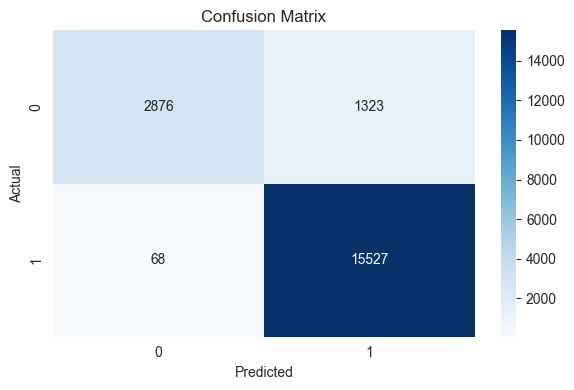

In [139]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()